## 0. Chargement des données

In [2]:
import pandas as pd

# Charger les données
synthetic_pricing_data_path = "data/synthetic_pricing_data_calibrated.csv"
df_synthetic_pricing_data = pd.read_csv(synthetic_pricing_data_path)

# Afficher les premières lignes des données
df_synthetic_pricing_data.head()

,order_requests,city_x,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy,price
0,1,8,21,22,0,1,161,46,1,8,1,0,0,204.835708
1,1,8,21,22,0,1,187,32,0,9,1,1,0,223.086785
2,1,8,21,22,0,1,279,12,3,7,1,0,0,292.384427
3,1,8,21,22,0,1,395,10,0,6,0,0,0,326.151493
4,1,8,21,22,0,1,488,42,0,14,1,1,1,218.292331


## 1. Préparer les données pour l'entraînement : Séparer les données en train/test

In [3]:
from sklearn.model_selection import train_test_split

# Définir les features (X) et la variable cible (y)
X = df_synthetic_pricing_data.drop(columns=["price", "hotel_id", "avatar_id"])  # Supprimer les identifiants inutiles
y = df_synthetic_pricing_data["price"]

# Division en jeu d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier la taille des ensembles
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5315, 11), (1329, 11), (5315,), (1329,))

## 2. Entraîner plusieurs modèles de Machine Learning

In [4]:
# Import des modèles
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialiser les modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
}

# Dictionnaire pour stocker les résultats
results = {}

# Entraînement et évaluation de chaque modèle
for name, model in models.items():
    print(f"🔄 Entraînement du modèle : {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse

# Afficher les résultats des modèles
results

🔄 Entraînement du modèle : Régression Linéaire...
🔄 Entraînement du modèle : Random Forest...
🔄 Entraînement du modèle : XGBoost...


{'Régression Linéaire': 62.571504567362766,
 'Random Forest': 55.74825849977741,
 'XGBoost': 56.561106133850984}

## 3. Optimiser les hyperparamètres avec GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV

# Hyperparamètres pour Random Forest
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"✅ Meilleurs paramètres pour Random Forest : {grid_rf.best_params_}")
print(f"🏆 Meilleur RMSE : {-grid_rf.best_score_}")

# Hyperparamètres pour XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 6, 10]
}

grid_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print(f"✅ Meilleurs paramètres pour XGBoost : {grid_xgb.best_params_}")
print(f"🏆 Meilleur RMSE : {-grid_xgb.best_score_}")

✅ Meilleurs paramètres pour Random Forest : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
🏆 Meilleur RMSE : 50.60233653404486
✅ Meilleurs paramètres pour XGBoost : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
🏆 Meilleur RMSE : 49.139641075789115


## 4. Visualiser les résultats

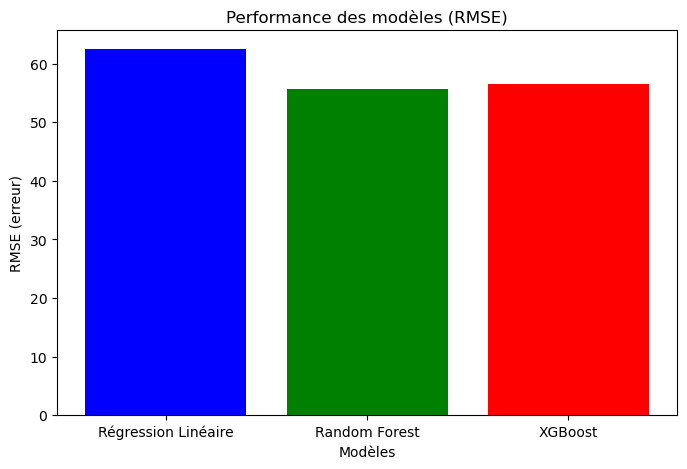

In [6]:
import matplotlib.pyplot as plt

# Afficher les performances des modèles
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=["blue", "green", "red"])
plt.title("Performance des modèles (RMSE)")
plt.xlabel("Modèles")
plt.ylabel("RMSE (erreur)")
plt.show()

## 5. sauvegardons le meilleur modèle dans le dossier backend/model

In [7]:
import joblib
import os

# Créer le dossier s'il n'existe pas
model_dir = "backend/model"
os.makedirs(model_dir, exist_ok=True)

# Sélectionner le meilleur modèle en fonction du RMSE
best_model_name = min(results, key=results.get)  # Modèle avec le plus petit RMSE
best_model = models[best_model_name]

# Définir le chemin de sauvegarde du modèle
model_filename = f"{best_model_name.replace(' ', '_').lower()}_model.pkl"
model_path = os.path.join(model_dir, model_filename)

# Sauvegarder le modèle
joblib.dump(best_model, model_path)

print(f"✅ Le modèle '{best_model_name}' a été sauvegardé sous : {model_path}")

✅ Le modèle 'Random Forest' a été sauvegardé sous : backend/model\random_forest_model.pkl
